### <b>Telecommunication Assistant - B2C </b>

Importing relevant packages

In [4]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv

import os
from langchain_huggingface import HuggingFaceEmbeddings
import faiss
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain.agents import initialize_agent, AgentType

load_dotenv()

True

Getting the API key from environment

In [5]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Telecom Assistant"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")

LLM Model - From Groq (Deepseek-r1)

In [6]:
model = ChatGroq(temperature=0, model_name="deepseek-r1-distill-llama-70b", streaming=True)
print(model.invoke("Chennai").content)

<think>

</think>

Chennai is the capital city of the Indian state of Tamil Nadu. It is a major cultural, economic, and educational center in South India. Chennai is known for its rich cultural heritage, including traditional Tamil arts, music, and dance. The city is also home to several historical landmarks, such as the Kapaleeshwarar Temple and Fort St. George, which reflect its colonial past.

Chennai is a hub for the automobile industry, earning it the nickname "Detroit of India." It is also a significant center for information technology and healthcare. The city is well-connected by air, land, and sea, with the Chennai International Airport and the Chennai Port being key infrastructure.

Chennai's cuisine is a blend of traditional Tamil dishes and modern fusion food. The city is famous for its filter coffee, idli, dosa, and other South Indian delicacies. Chennai also hosts several cultural festivals throughout the year, including the Margazhi festival, which showcases classical mu

In [7]:
#Vector Embeddings (Embedding Model Output features : 384)

from langchain.embeddings import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", model_kwargs = {"device" : "cpu"})
embedding_model

C:\Users\bharath.sr.lv\AppData\Local\Temp\ipykernel_4172\3273188620.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", model_kwargs = {"device" : "cpu"})
c:\Users\bharath.sr.lv\Desktop\ConversationalAI\Telecom_Assistant_POC\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={'device': 'cpu'}, encode_kwargs={}, multi_process=False, show_progress=False)

Loading the FAISS Vector Indices from local

In [8]:
#Local
from langchain_community.vectorstores import FAISS
from langchain_community.docstore import InMemoryDocstore

local_vector_db = FAISS.load_local("C:/Users/bharath.sr.lv/Desktop/ConversationalAI/Telecom_Assistant_POC/Telecom_Agent/conversation_faiss_index",
                                    embeddings=embedding_model,
                                    allow_dangerous_deserialization=True)

retriever = local_vector_db.as_retriever(search_kwargs ={"k":5})

retriever.invoke("I am facing connection issues during peak work time")

[Document(id='684edc83-0fcb-4956-b34f-1cb87e5b577e', metadata={'intent': 'report_poor_signal_coverage'}, page_content='"Instruction: \n    id like to report poor internet signalcoverage will uhelp me\n    Intent: report_poor_signal_coverage\n    Category: COMPLAINTS\n    Tags: BCILPQZ\n    Response: We recognize the importance of reliable signal coverage for effective communication. Please adhere to the following steps to report any issues you are experiencing with signal coverage:\r\n\r\n1. Visit our website at {{WEBSITE_URL}}.\r\n2. Navigate to the {{SUPPORT_SECTION}} section.\r\n3. Select the option labeled {{REPORT_POOR_SIGNAL_COVERAGE_OPTION}}.\r\n4. Fill in the required details, including your location and issue description.\r\n5. Submit the form to notify our team.\r\n\r\nOur team will investigate your report and take appropriate measures to enhance the network coverage in your vicinity.'),
 Document(id='3730584b-f5d3-42ce-91de-03dbf2c36c02', metadata={'intent': 'report_poor_sig

##### LangGraph Implementation

For Intent classification Using Pydantic output Parser

In [128]:
from typing import TypedDict, List, Optional
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class AgentState(TypedDict):
    messages: List
    customer_id: Optional[str]
    intent: Optional[str]
    user_query: Optional[str]
    customer_data: Optional[str]
    retrieved_context: Optional[str]


#Using pydantic

class Intent_Classifier(BaseModel):
    """Intent Classifier"""
    customer_id: str = Field(description="The customer ID in the format CUSTXXXX")
    intent: str = Field(description="Intent of the user query")
    query: str = Field(description="User query")
    Reasoning: str = Field(description='Reasoning behind topic selection')


parser = PydanticOutputParser(pydantic_object=Intent_Classifier)

print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Intent Classifier", "properties": {"customer_id": {"description": "The customer ID in the format CUSTXXXX", "title": "Customer Id", "type": "string"}, "intent": {"description": "Intent of the user query", "title": "Intent", "type": "string"}, "query": {"description": "User query", "title": "Query", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["customer_id", "intent", "query", "Reasoning"]}
```


Creating State Graph using Langflow

In [129]:
import operator
from typing import List
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

llm = ChatGroq(temperature=0, model_name="deepseek-r1-distill-llama-70b", streaming=True)

Supervisor Node (Intent node)

In [244]:
def supervisor_node(state: AgentState) -> AgentState:
    
    print("--------------------------Supervisor---------------------------")
    # user_question = state["messages"][-1].content
    messages = state["messages"]
    user_question = messages[-1].content

    template  = """
        You are a telecom assistant that classifies the user's intent into one of the following:
    - Plan: If the user is asking about mobile, broadband, or 5G plans.
    - Complaint: If the user is reporting issues like network outage, slow internet, or billing problems.
    - Other: For greetings, general questions, or unrelated topics.

    Your job is to classify the intent and explain your reasoning.

    User Query: {question}

    {format_instructions}
    """
    prompt = PromptTemplate(
        input_variables = ["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
        template = template
    )

    chain = prompt | llm | parser

    try:
        response = chain.invoke({"question": user_question})
        print("Parsed Response:", response)
    except Exception as e:
        print("Supervisor chain failed:", e)
        response = None



    return {
        "messages": state["messages"] + [
            AIMessage(content=f"Intent: {response.intent}"),
            AIMessage(content=f"Reasoning: {response.Reasoning}"),
            AIMessage(content=f"Customer ID: {response.customer_id}")
        ],
        "customer_id": response.customer_id,
        "intent": response.intent,
        "user_query": response.query
    }


In [245]:
#check
state = {
    "messages": [
        HumanMessage(content="My Plan is not sufficient and i need more data what can I do My ID is CUST1001?")
    ]
}
supervisor_node(state)

# state = {
#     "messages": [
#         HumanMessage(content="I am facing buffering issue with my plan and there is no speed in 5G band and though I pay for 5G")
#     ]
# }
# supervisor_node(state)

--------------------------Supervisor---------------------------
Parsed Response: customer_id='CUST1001' intent='Plan' query='My Plan is not sufficient and i need more data what can I do My ID is CUST1001?' Reasoning='The user is discussing their current plan and the need for more data, which falls under the Plan category as they are seeking information or changes related to their mobile or broadband plan.'


{'messages': [HumanMessage(content='My Plan is not sufficient and i need more data what can I do My ID is CUST1001?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Intent: Plan', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Reasoning: The user is discussing their current plan and the need for more data, which falls under the Plan category as they are seeking information or changes related to their mobile or broadband plan.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Customer ID: CUST1001', additional_kwargs={}, response_metadata={})],
 'customer_id': 'CUST1001',
 'intent': 'Plan',
 'user_query': 'My Plan is not sufficient and i need more data what can I do My ID is CUST1001?'}

##### Creating SQL Agent

In [246]:
from langchain_groq import ChatGroq
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import Tool
from langchain.agents import AgentExecutor, create_openai_functions_agent
import re
from langchain.agents import initialize_agent

In [283]:
import sqlite3

def get_customer_details(customer_id: str, db_path: str) -> dict:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
    SELECT 
        "Customer ID", "Customer Name", Age, Gender, Location,
        "Plan Subscribed", "Device Used", "Plan Details",
        "Network Type", "Join Date", "Recent Issue Reported", "Response Provided"
    FROM customers
    WHERE "Customer ID" = ?
    """

    cursor.execute(query, (customer_id,))
    row = cursor.fetchone()
    conn.close()

    if not row:
        return None

    keys = [
        "Customer ID", "Customer Name", "Age", "Gender", "Location",
        "Plan Subscribed", "Device Used", "Plan Details",
        "Network Type", "Join Date", "Recent Issue Reported", "Response Provided"
    ]
    return dict(zip(keys, row))



In [284]:
def SQL_agent(state: dict) -> dict:
    print("------------ SQL Agent Node (Direct SQL) ------------")

    customer_id = state.get("customer_id")
    if not customer_id:
        return {
            **state,
            "messages": state["messages"] + [("assistant", "Customer ID is missing.")],
            "customer_data": None
        }

    customer_data = get_customer_details(customer_id, db_path="telecom_customer.db")

    if customer_data is None:
        return {
            **state,
            "messages": state["messages"] + [("assistant", f"No customer found with ID: {customer_id}")],
            "customer_data": None
        }

    print(f"Customer_data: {customer_data}")

    return {
        **state,
        "messages": state["messages"] + [("assistant", f"Customer data fetched for ID {customer_id}.")],
        "customer_data": customer_data
    }


In [285]:
#check

state = {
    "customer_id": "CUST1011",
    "messages": [("user", "Tell me about my current plan")]
}

new_state = SQL_agent(state)
print(new_state["customer_data"])

------------ SQL Agent Node (Direct SQL) ------------
Customer_data: {'Customer ID': 'CUST1011', 'Customer Name': 'Frank Lester', 'Age': 46, 'Gender': 'Male', 'Location': 'New Rebecca', 'Plan Subscribed': 'Data-Only Plan', 'Device Used': 'Samsung Galaxy S22', 'Plan Details': 'Costs $15to\x93$25/month, offers 10to\x9320 GB high-speed data, no calls/SMS, 512 Kbps after limit, supports tethering and hotspot use.', 'Network Type': 'LTE', 'Join Date': '23-10-2023', 'Recent Issue Reported': 'No network coverage in area', 'Response Provided': 'We are sorry. We will ship a new one.'}
{'Customer ID': 'CUST1011', 'Customer Name': 'Frank Lester', 'Age': 46, 'Gender': 'Male', 'Location': 'New Rebecca', 'Plan Subscribed': 'Data-Only Plan', 'Device Used': 'Samsung Galaxy S22', 'Plan Details': 'Costs $15to\x93$25/month, offers 10to\x9320 GB high-speed data, no calls/SMS, 512 Kbps after limit, supports tethering and hotspot use.', 'Network Type': 'LTE', 'Join Date': '23-10-2023', 'Recent Issue Reporte

##### RAG Agent

In [286]:
from langchain_core.tools import tool
from langchain_core.messages import AIMessage

def RAG_agent(state: AgentState) -> AgentState:
    print("--------------------------RAG Agent Node---------------------------")
    query = state.get("user_query")

    """
    Combines the user query and SQL customer context to retrieve the most relevant information 
    from the vector DB (e.g. troubleshooting guides, plan info, etc.).

    Parameters:
    - query (str): The user's original question (e.g., "Why is my network slow?")
    - customer_context (str): The context retrieved from SQL agent (e.g., customer location, plan, device)

    Returns:
    - str: Top-k retrieved document contents concatenated.
    """

    # Assuming local_vector_db is already loaded globally with embeddings
    retriever = local_vector_db.as_retriever(search_kwargs={"k": 5})
    documents = retriever.invoke(query)

    context = "\n\n".join([doc.page_content for doc in documents])

    print(f"Retrieved context for query '{query}':\n{context}\n")

    return {
        "messages": state["messages"] + [AIMessage(content=context)],
        "retrieved_context": context
    }


In [287]:
#check
# Simulate a fake state to test
fake_state = {
    "user_query": "I am facing internet issues with my login to the app",
    "messages": []
}

# Test the node
updated_state = RAG_agent(fake_state)

# Print output
print(updated_state["retrieved_context"])

--------------------------RAG Agent Node---------------------------
Retrieved context for query 'I am facing internet issues with my login to the app':
"Instruction: 
    I got to report the fucking internet faults, could you help mr?
    Intent: report_problem
    Category: COMPLAINTS
    Tags: BCIMPWZ
    Response: To report an issue with your {{SERVICE_TYPE}}, please follow these steps:

1. Visit our official website at {{WEBSITE_URL}}.
2. Log in to your account using your credentials.
3. Navigate to the {{SUPPORT_SECTION}} section.
4. Select the option to {{REPORT_PROBLEM_OPTION}}.
5. Provide detailed information about the issue you are experiencing.
6. Submit the report.

If you require any additional support, do not hesitate to contact our support team for further assistance.

"Instruction: 
    I need assistamce to set up the fucking internet in my home
    Intent: install_internet
    Category: SERVICES
    Tags: BLWZ
    Response: To establish an internet connection at your re

Plan Explainer & Marketer

In [288]:
from langchain_core.output_parsers import StrOutputParser
import json

plan_explainer_parser = StrOutputParser()

def extract_first_json_block(text: str) -> str:
    brace_count = 0
    start_index = None
    for i, char in enumerate(text):
        if char == '{':
            if brace_count == 0:
                start_index = i
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0 and start_index is not None:
                return text[start_index:i + 1]
    raise ValueError("No valid JSON object found.")

def Plan_Explainer(state: AgentState) -> AgentState:
    print("--------------------------Plan Explainer---------------------------")

    query = state.get("user_query")
    intent = "plan"
    customer_id = state.get("customer_id")
    customer_data = state.get("customer_data")

    print(f"Customer_data :{customer_data}\n customer_id :{customer_id}")

    plan_info = """
    1. Basic Plan: $20–$30/month, includes 5 GB high-speed data, unlimited calls, 1000 SMS/month, 128 Kbps after limit, no roaming.
    2. Unlimited Plan: $30–$50/month, truly unlimited data (FUP after 50 GB), unlimited calls/SMS, 1 Mbps post-FUP, 5G, cloud storage, hotspot.
    3. Family Plan: $60–$100/month for 3–5 lines, shared 50–100 GB data, unlimited calls/SMS, 256 Kbps post-limit, includes parental controls.
    4. Premium Plan: $40–$60/month, unlimited high-speed (throttled after 100 GB), includes international calls, priority support, streaming.
    5. Data-Only Plan: $15–$25/month, 10–20 GB high-speed data, no calls/SMS, 512 Kbps post-limit, supports tethering and hotspots.
    """
    format_instructions = """
    Return a JSON object with the following keys:
    - plan_details
    - query_response
    - cross_sell_recommendation
    - reasoning
    """

    template = """
    You are a telecom marketing assistant. Your job is to address the user by name and explain the user's current plan clearly and offer an upgrade suggestion **only if appropriate**.

    You must perform the following tasks:
    1. Summarize the customer's **current plan** in simple, friendly language.
    2. Explain how the plan features address the user's query.
    3. If the plan is **outdated**, **limited**, or **not optimal** based on their usage, suggest an **upgrade** (cross-sell) with a compelling reason.
    4. Be helpful, not pushy. Do not upsell if the user is already on a top-tier plan
    5. Keep the intent in mind while responding.
    6. Do not change the intent reposnse, keep it as such like "Plan" or "Complaint", Don't add any additional words to it.

    Use the information below:

    ---
    **Available Data**:
    {plan_info}

    **Customer Data**:
    {customer_data}

    **User Query**:
    {query}

    **Intent**: {intent}  
    
    **Customer ID**: {customer_id}

    Given a customer's current data, current and query, respond in the following JSON format:

    {{
    "plan_details": "...",
    "query_response": "...",
    "cross_sell_recommendation": "...",
    "reasoning": "..."
    }}
    """

    prompt = PromptTemplate(
        input_variables=["customer_data", "query", "intent", "customer_id", "plan_info"],
        template=template
    )

    chain = prompt | llm | plan_explainer_parser
    response = chain.invoke({
        "query": query,
        "customer_data": customer_data,
        "intent": intent,
        "customer_id": customer_id,
        "plan_info": plan_info
    })

    print("Plan Explainer Response:", response)

    json_match = re.search(r"\{[\s\S]*\}", response)
    try:
        json_part = extract_first_json_block(response)
        response = json.loads(json_part)
    except Exception as e:
        print("JSON decode error:", e)
        return state

#     return {
#     **state,
#     "messages": state["messages"] + [AIMessage(content=str(response))],
#     "plan_details": response["plan_details"],
#     "query_response": response["query_response"],
#     "cross_sell_recommendation": response["cross_sell_recommendation"],
#     "reasoning": response["reasoning"],
#     "intent": "plan",
# }

    return {
    **state,
    "messages": state["messages"] + [AIMessage(content=str(response))],
    "plan_details": response.get("plan_details"),
    "query_response": response.get("query_response"),
    "cross_sell_recommendation": response.get("cross_sell_recommendation"),
    "reasoning": response.get("reasoning"),
    "intent": "plan", 
}


In [289]:
#check

sample_state = {
    "user_query": "I'm getting a lot of overage charges lately. Is there a better plan for heavy data users?",
    "intent": "Plan",
    "customer_id": "CUST1234",
    "customer_data": {
        "name": "Ravi Kumar",
        "current_plan": "Basic Plan",
        "monthly_usage_gb": 12,
        "calls_per_month": 800,
        "sms_per_month": 500,
        "monthly_bill_usd": 28
    },
    "messages": []
}

updated_state = Plan_Explainer(sample_state)

print("Plan Details:", updated_state.get("plan_details"))
print("Customer ID:", updated_state.get("customer_id"))
print("Cross-sell Recommendation:", updated_state.get("cross_sell_recommendation"))

--------------------------Plan Explainer---------------------------
Customer_data :{'name': 'Ravi Kumar', 'current_plan': 'Basic Plan', 'monthly_usage_gb': 12, 'calls_per_month': 800, 'sms_per_month': 500, 'monthly_bill_usd': 28}
 customer_id :CUST1234
Plan Explainer Response: <think>
Okay, so I need to help Ravi Kumar with his telecom plan. He's on the Basic Plan right now, which costs him $28 a month. Let me look at the details of his current plan. It includes 5 GB of high-speed data, unlimited calls, 1000 SMS per month, and after he uses up the 5 GB, the speed drops to 128 Kbps. He doesn't get any roaming either.

Ravi's usage is 12 GB of data each month, which is way more than the 5 GB his plan offers. That explains why he's getting overage charges. He's also making 800 calls and sending 500 SMS, which is within the limits of his current plan since it offers unlimited calls and 1000 SMS. So, his main issue is the data overage.

He's asking if there's a better plan for heavy data us

##### Summarizer

In [360]:
from langchain.prompts import PromptTemplate
from langchain_core.messages import AIMessage
import ast

def summarizer_agent(state: AgentState) -> AgentState:
    print("--------------------------Summarizer Node---------------------------")

    intent = state.get("intent", "").lower()
    customer_id = state.get("customer_id")
    user_query = state["messages"][0].content

    # Get the last assistant message
    last_message = state["messages"][-1]

    try:
        # Parse the string as a Python dict
        plan_explainer_msg = ast.literal_eval(last_message.content)
    except Exception as e:
        print("Failed to parse message content:", e)
        plan_explainer_msg = {}

    plan_details = plan_explainer_msg.get("plan_details", "")
    query_response = plan_explainer_msg.get("query_response", "")
    cross_sell_recommendation = plan_explainer_msg.get("cross_sell_recommendation", "")
    reasoning = plan_explainer_msg.get("reasoning", "")

    print("Intent:", intent)
    print("Customer ID:", customer_id)
    print("User Query:", user_query)
    print("Plan Details:", plan_details)
    print("Query Response:", query_response)
    print("Cross-sell Recommendation:", cross_sell_recommendation)

    base_inputs = {
        "customer_id": customer_id,
        "query": user_query,
    }

    if intent == "plan":
        template = """
You are a warm, friendly telecom assistant. Write a helpful and human-like message in response to the user's plan concerns.

- Begin with a friendly greeting and apology (include emoji like 👋 and 😊).
- Mention the current plan (use what's given in "Plan Details").
- Acknowledge the user's concern and recommend an upgraded plan if relevant.
- Explain benefits in a simple and friendly tone.
- End with a question like: "Would you like me to help you upgrade or explore other options?"

Compose the message in a conversational tone. DO NOT include <think> or reasoning steps.

---
Customer ID: {customer_id}
User Query: {user_query}
Plan Details: {plan_details}
Query Response: {query_response}
Recommended Upgrade: {cross_sell_recommendation}
        """

        inputs = {
            **base_inputs,
            "user_query": user_query,  #  corrected to user_query
            "plan_details": plan_details, 
            "query_response": query_response,
            "cross_sell_recommendation": cross_sell_recommendation,
            
        }

    elif intent == "complaint":
        grievance_context = state.get("retrieved_context", "")
        complaint_response = state.get("complaint_resolution", "")

        template = """
You are a kind and professional telecom assistant helping a customer with a complaint.


Your goal is to:
- Understand the user’s concern from their query.
- Read the retrieved context (which may include a general solution from other similar cases).
- Use the resolution (if any) to provide a reassuring and helpful response.
- Empathize with the customer. Keep your tone friendly, polite, and professional.
- DO NOT refer to the context or resolution as being from another user — just use it to help you answer.
- DO NOT mention bullet points, tags, or internal data. Just give a natural, conversational response in 3–4 lines.

---
Customer ID: {customer_id}
User Query: {query}
Context: {grievance_context}
Resolution: {complaint_response}
        """

        inputs = {
            **base_inputs,
            "grievance_context": grievance_context,
            "complaint_response": complaint_response
        }

    else:
        template = """
You are a friendly assistant. Acknowledge the user's query and let them know you'll look into it.

---
Customer ID: {customer_id}
User Query: {user_query}
        """
        inputs = base_inputs

    prompt = PromptTemplate.from_template(template)
    chain = prompt | llm
    response = chain.invoke(inputs)

    summary_text = response.content if hasattr(response, "content") else str(response)
    print("Generated Summary:", summary_text)

    return {
        **state,
        "messages": state.get("messages", []) + [AIMessage(content=summary_text)],
        "summary": summary_text
    }


Router

In [361]:
def Router(state: AgentState) -> str:
    """
    Determines the next node to route to based on the user's intent or message content.
    """
    print("--------------------------Router Node---------------------------")

    # last_msg = state["messages"][-1][1].lower().strip()

    # follow_ups = ["yes", "yeah", "yep", "sure", "okay", "ok", "sounds good", "go ahead"]
    # if last_msg in follow_ups:
    #     return "follow_up_handler"  

    intent = state.get("intent", "").lower()

    if intent == "plan":
        return "Plan_Explainer"
    elif intent == "complaint":
        return "RAG_agent"
    else:
        return "summarizer_agent"


In [362]:
# def pre_router(state: AgentState) -> str:
#     last_msg = state["messages"][-1].content.lower().strip()
#     follow_ups = ["yes", "okay", "sure", "sounds good", "ok", "yep"]
    
#     if last_msg in follow_ups:
#         return "follow_up_handler"
#     return "supervisor_agent"

In [363]:
# def follow_up_handler(state: dict) -> dict:
#     print("--------------------------Follow-Up Handler---------------------------")

#     plan = state.get("cross_sell_recommendation", "the suggested plan")
    
#     message = f"Great! Let's proceed with upgrading to {plan}. I’ll guide you through the next steps. 😊"

#     return {
#         **state,
#         "messages": state["messages"] + [AIMessage(content=message)],
#         "action": "continue_upgrade"
#     }


Implementing Langgraph

In [364]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [365]:
app_workflow = StateGraph(AgentState)

# Add actual processing nodes (functions that return dict)
app_workflow.add_node("supervisor_agent", supervisor_node)
app_workflow.add_node("SQL_agent", SQL_agent)
app_workflow.add_node("RAG_agent", RAG_agent)
app_workflow.add_node("Plan_Explainer", Plan_Explainer)
app_workflow.add_node("summarizer_agent", summarizer_agent)
# app_workflow.add_node("follow_up_handler", follow_up_handler)

# Correct conditional entry point from START using pre_router
# app_workflow.add_conditional_edges(
#     START,
#     pre_router,
#     {
#         "follow_up_handler": "follow_up_handler",
#         "supervisor_agent": "supervisor_agent"
#     }
# )

# Supervisor always goes to SQL
app_workflow.add_edge("supervisor_agent", "SQL_agent")
app_workflow.add_edge(START, "supervisor_agent")
# Conditional routing from SQL agent
app_workflow.add_conditional_edges(
    "SQL_agent",
    Router,
    {
        "Plan_Explainer": "Plan_Explainer",
        "RAG_agent": "RAG_agent",
        "summarizer_agent": "summarizer_agent",
        # "follow_up_handler": "follow_up_handler"
    }
)

# Plan/Complaint/Follow-up → summarizer → END
app_workflow.add_edge("Plan_Explainer", "summarizer_agent")
app_workflow.add_edge("RAG_agent", "summarizer_agent")
# app_workflow.add_edge("follow_up_handler", "summarizer_agent")
app_workflow.add_edge("summarizer_agent", END)


In [366]:
import uuid

thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

In [367]:
app = app_workflow.compile(checkpointer= memory)

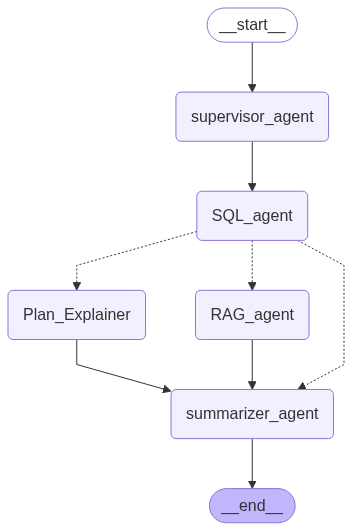

In [368]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [370]:
sample_state = {
    "messages": [
        HumanMessage(content="Hi my customer id is CUST1013. Explain my plan")
    ]
}

from langchain_core.messages import HumanMessage
flow_response = app.invoke(sample_state, config=config)

--------------------------Supervisor---------------------------
Parsed Response: customer_id='CUST1013' intent='Plan' query='Hi my customer id is CUST1013. Explain my plan' Reasoning='The user is asking for an explanation of their current plan, which falls under the Plan intent.'
------------ SQL Agent Node (Direct SQL) ------------
Customer_data: {'Customer ID': 'CUST1013', 'Customer Name': 'Ryan Larson', 'Age': 68, 'Gender': 'Male', 'Location': 'Vegafort', 'Plan Subscribed': 'Data-Only Plan', 'Device Used': 'Motorola Edge', 'Plan Details': 'Costs $15to\x93$25/month, offers 10to\x9320 GB high-speed data, no calls/SMS, 512 Kbps after limit, supports tethering and hotspot use.', 'Network Type': '5G', 'Join Date': '10-02-2024', 'Recent Issue Reported': 'SIM not activated', 'Response Provided': 'Please restart your device to refresh network settings.'}
--------------------------Router Node---------------------------
--------------------------Plan Explainer---------------------------
Custo